# 1. Практична робота

In [1]:
import spacy
import numpy as np

nlp = spacy.load('/tmp/uk_vectors')

In [2]:
w1 = nlp('озеро')[0]
w2 = nlp('вода')[0]

In [3]:
def cos(a, b):
    return np.divide(np.dot(a, b), np.multiply(np.linalg.norm(a), np.linalg.norm(b)))

In [4]:
cos(w1.vector, w2.vector)

0.38325295

In [5]:
def closest_v1(text):
    w1 = nlp(text)[0]
    v = w1.vector
    max = 0
    closest = None
    for w2 in nlp.vocab:
        if not v in w2.vector:
            dist = cos(w1.vector, w2.vector)
            if dist < 0.99 and dist > max:
                max = dist
                closest = w2
    return (closest.text, max)

In [6]:
closest_v1('людина')

<ipython-input-3-0a2071d0783f>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(np.dot(a, b), np.multiply(np.linalg.norm(a), np.linalg.norm(b)))


('жінка', 0.80138385)

In [7]:
def vec(text):
    return nlp(text)[0].vector

def closest_v2(v, n = 10):
    result = []
    
    for w in nlp.vocab:
        if not v in w.vector:
            dist = cos(v, w.vector)
            if not result or (dist < 0.99 and dist > result[0][1]):
                if len(result) > n:
                    result.pop(0)
                result.append((w.text, dist))
 
                
    return sorted(result, key=lambda x: x[1], reverse=True)

In [10]:
closest_v2(vec('король') - vec('чоловік') + vec('жінка'), 10)

<ipython-input-3-0a2071d0783f>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(np.dot(a, b), np.multiply(np.linalg.norm(a), np.linalg.norm(b)))


[('королева', 0.6347344),
 ('принцеса', 0.56770325),
 ('дама', 0.5491234),
 ('Королева', 0.50412023),
 ('балерина', 0.4840115),
 ('наречена', 0.46061063),
 ('трійця', 0.4406501),
 ('фігура', 0.40448746),
 ('індіанка', 0.3871581),
 ('опозицiя', 0.31442997),
 ('оаза', 0.31302285)]

In [9]:
closest_v2(vec('дуб') - vec('дерево'))

<ipython-input-3-0a2071d0783f>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(np.dot(a, b), np.multiply(np.linalg.norm(a), np.linalg.norm(b)))


[('достойник', 0.32148564),
 ('центризм', 0.30659607),
 ('поборник', 0.27024013),
 ('реформатор', 0.26169586),
 ('рітейлер', 0.24086595),
 ('романтизм', 0.23508115),
 ('мотиватор', 0.23270722),
 ('суверен', 0.21718358),
 ('Шуплер', 0.1919113),
 ('_законопроект', 0.13323738),
 ('Хмельницький', 0.1072683)]

In [14]:
import json
import gzip
import glob

PATH = '1551.gov.ua/raw/'
file = 'А/А-10008.json.gz'

with gzip.open(PATH + file, 'rb') as f:
    obj = json.load(f)

In [15]:
data = []

def read_file(path):
    with gzip.open(path, 'rb') as f:
        req = json.load(f)
        return req[0]['CallZText'], req[0]['CallZType']

for path in glob.glob(PATH + '*/*'):
    data.append(read_file(path))

In [17]:
import pandas as pd

In [18]:
df = pd.DataFrame(data, columns=['text', 'category'])

In [19]:
df[:5]

,text,category
0,Хочу подякувати головному інженеру ТОВ ”Житлов...,Подяки головному інженеру ЖЕКу
1,Почему опять нет горячей воды? Я видел что за ...,Відсутність ГВП
2,"не має гарячої води, замість гарячої - холодна...",Відсутність ГВП
3,На вулиці Байковій присутня дошка з інформаціє...,Встановлення меморіальних дощок видатним діяча...
4,Добрый день! По улице Жуковского возле дома №...,Облаштування та технічний стан бюветного компл...


In [20]:
len(df)

127329

In [21]:
len(df['category'])

127329

In [22]:
len(df[df.text == ''])

540

In [23]:
df['category'].value_counts()[:10]

Відсутність ГВП                                                                     13273
Укладання та ремонт асфальтного покриття                                             6632
Відсутність опалення                                                                 6020
Перевірка дозвільної документації, демонтаж кіосків, ларків                          3654
Прибирання та санітарний стан територій                                              3084
Не працює пасажирський ліфт                                                          2718
Відсутність освітлення у під’їзді за відсутності/несправності лампочок               2637
Відновлення благоустрою після вик. планових,аварійних робіт на об’єктах благоуст     2393
Незадовільна температура ГВП                                                         2304
Технічний стан проїжджих частин вулиць та тротуарів                                  2180
Name: category, dtype: int64

In [24]:
top10 = df['category'].value_counts()[:10].index.to_list()

len(df[df.category.isin(top10)])

44895

In [25]:
cleaned_df = df[(df.text != '') & df.category.isin(top10)]

In [26]:
from tokenize_uk import tokenize_uk

def vectorize(text):
    v = vec('unk')
    
    tokens = tokenize_uk.tokenize_words(text)
    
    for t in tokens:        
        v += vec(t)
            
    v /= len(tokens)

    return v

In [27]:
cleaned_df['text_vec'] = cleaned_df.text.apply(vectorize)

<ipython-input-27-004066f98054>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['text_vec'] = cleaned_df.text.apply(vectorize)


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

x, y = np.vstack(cleaned_df['text_vec']), np.hstack(cleaned_df['category'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

neigh = KNeighborsClassifier(n_neighbors=10, metric='cosine', n_jobs=-1)
neigh.fit(X_train, y_train_encoded)

y_pred = neigh.predict(X_test)

In [30]:
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

                                                                                  precision    recall  f1-score   support

Відновлення благоустрою після вик. планових,аварійних робіт на об’єктах благоуст       0.40      0.32      0.35       795
                                                                 Відсутність ГВП       0.58      0.90      0.70      4357
                                                            Відсутність опалення       0.63      0.47      0.54      1991
          Відсутність освітлення у під’їзді за відсутності/несправності лампочок       0.65      0.52      0.58       896
                                                     Не працює пасажирський ліфт       0.71      0.49      0.58       919
                                                    Незадовільна температура ГВП       0.65      0.34      0.44       766
                     Перевірка дозвільної документації, демонтаж кіосків, ларків       0.67      0.67      0.67      1187
                       

In [31]:
# That's an impressive list of imports.
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# from sklearn.utils.extmath import _ravel
from numpy import ravel as _ravel

# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

/Users/h8si2w8/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [32]:
df = pd.DataFrame(list(zip(X_train, y_train_encoded)), columns=['data','target'])

x = np.vstack([[v for v in df.data[df.target==i].values]
               for i in range(10)])
y = np.hstack([[v for v in df.target[df.target==i].values]
               for i in range(10)])

In [36]:
digits_proj = TSNE(random_state=RS, n_jobs=-1, perplexity=10).fit_transform(x)

In [39]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(16, 16))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=20,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

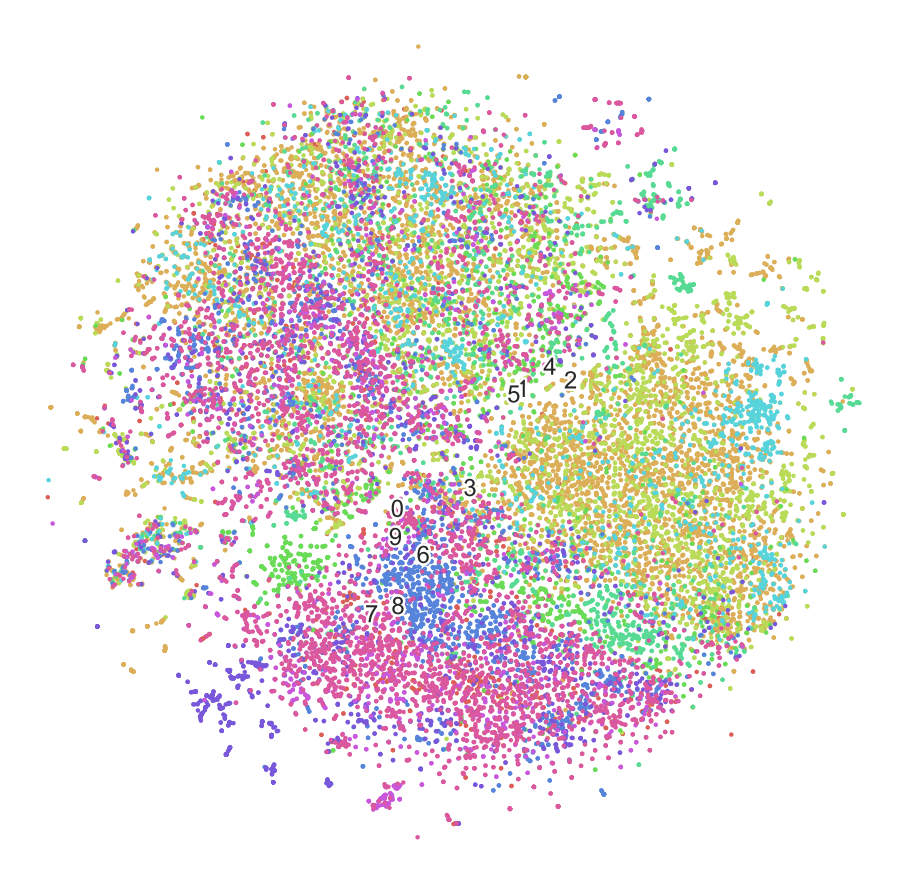

In [40]:
scatter(digits_proj, y)
None

**Далі:** [Передобробка даних](02-vectors-data.ipynb)